This file is part of F1StrategyAssistent.

F1StrategyAssistent is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

F1StrategyAssistent is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

F1StrategyAssistent is unofficial and is not associated in any way with the Formula 1 companies. F1, FORMULA ONE, FORMULA 1, FIA FORMULA ONE WORLD CHAMPIONSHIP, GRAND PRIX and related marks are trade marks of Formula One Licensing B.V.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import fastf1 as ff1
import fastf1.plotting

In [2]:
pit_stop_cost={
    'Canada': 0.18,
    'United Kingdon': 0.20,
    'Italy': 0.23,
    'Bahrein': 0.23,
    'Saudi Arabia': 0.2
}

pit_stop_cost_sc={
    'Canada':0.9,
    'United Kingdon':0.9,
    'Italy': 0.15,
    'Bahrein': 16,
    'Saudi Arabia': 0.11

}

In [ ]:
def gpData(year, country, session):
    """
    Parameters:
        year (int): The year of the race (e.g., 2023, 2024).
        country (str): The country where the race is held (e.g., 'Saudi Arabia').
        session (str): The session of the race (e.g., 'r' for race, 'q' for qualifying).

    Returns:
        race (DataFrame): A DataFrame containing lap-level data and derived features.
        pitting (Series): A series indicating whether a pit stop occurred (1 for pit, 0 for no pit).
    """

    # Load the specified session using the FastF1 API
    session = ff1.get_session(year, country, session)
    session.load()

    # Extract lap data and sort by lap number and position
    laps = session.laps
    laps.sort_values(by=['LapNumber', 'Position'], inplace=True)
    laps.reset_index(drop=True, inplace=True)

    # Get weather data for the session
    weather = laps.get_weather_data()

    # Create the race DataFrame with relevant lap-level data
    race = pd.DataFrame({
        'LapNumber': laps['LapNumber'].values,
        'Position': laps['Position'].values,
        'Compound': laps['Compound'].values,
        'TyreLife': laps['TyreLife'].values,
        'TrackStatus': laps['TrackStatus'].map(lambda x: 1 if x == 4 else (2 if x == 6 else 0)),
        'TrackTemp': weather['TrackTemp'].values,
        'Rainfall': weather['Rainfall'].values.astype(int)
    })


    # Calculate the delta time between consecutive laps for each driver
    lap_time_delta = pd.Series()

    for i, driver in laps.groupby('Driver'):
        delta =[]
        delta = driver['LapTime'].dt.total_seconds().diff()
        delta.fillna(0, inplace=True)
        lap_time_delta = pd.concat([lap_time_delta, delta])

    race['DeltaTime'] = lap_time_delta


    # Calculate average distance to the driver ahead over a lap in seconds
    gap = []
    for i, l in laps.iterlaps():
        dist = l.get_telemetry().DistanceToDriverAhead
        speed = l.get_telemetry().Speed*3.6

        gap.append((dist/speed).mean())

    race['GapAhead'] = gap
    race['GapAhead'].replace(np.inf,np.nan, inplace=True)
    race['GapAhead'].fillna(0, inplace=True)

    
    # Add country of the race
    race['Country'] = session.event.Country

    
    # Calculate the number of positions that would be lost if the driver pitted in that lap
    lost_pos = []

    for i,group in race.groupby('LapNumber'):
        k = 0
        for j in group.index:
            if group.loc[j,'TrackStatus'] == 0:
                pit_loss = 0.2
                
            else :
                pit_loss = 0.11
            counter = 1
            loss = 0
            while (loss < pit_loss) & ((k+counter) < group.index.size):
                loss += group.loc[j+counter,'GapAhead']
                counter += 1

            lost_pos.append(counter)
            k += 1

    race['PosToLose'] = lost_pos

    
    race['TotalLaps'] = laps['LapNumber'].max()
    race['RemainingLaps'] = race['TotalLaps'] - race['LapNumber']

    
    laps.sort_values(by=['Driver', 'LapNumber'], inplace=True)
    
   # Define the condition when a car is making a pit stop
    pit_stop_condition = (
    (laps['PitInTime'].notna()) &
    (laps['TyreLife'] >= laps['TyreLife'].shift(-1)) &
    (laps['PitOutTime'].shift(-1).notna())
    )

    # Create a target series for pit stop (1 for pit, 0 for no pit)
    pitting = pd.Series(np.where(pit_stop_condition, 1, 0))
    pitting.index = laps.index
    pitting.sort_index(inplace=True)

    return race, pitting

In [14]:
# session = ff1.get_session(2023, 'Saudi', 'r')
# session.load()
laps = session.laps
laps.sort_values(by=['LapNumber', 'Position'], inplace=True)
laps.reset_index(drop=True, inplace=True)
weather = laps.get_weather_data()
race = pd.DataFrame({
    'LapNumber': laps['LapNumber'].values,
    'Position': laps['Position'].values,
    'Compound': laps['Compound'].values,
    'TyreLife': laps['TyreLife'].values,
    'TrackStatus': laps['TrackStatus'].map(lambda x: 1 if x == 4 else (2 if x == 6 else 0)),
    'TrackTemp': weather['TrackTemp'].values,
    'Rainfall': weather['Rainfall'].values.astype(int)
})
race['RoundNumber'] = session.event.RoundNumber

In [15]:
race.head(10)

,LapNumber,Position,Compound,TyreLife,TrackStatus,TrackTemp,Rainfall,RoundNumber
0,1.0,1.0,MEDIUM,1.0,0,31.6,0,2
1,1.0,2.0,MEDIUM,1.0,0,31.6,0,2
2,1.0,3.0,MEDIUM,1.0,0,31.6,0,2
3,1.0,4.0,MEDIUM,1.0,0,31.6,0,2
4,1.0,5.0,MEDIUM,1.0,0,31.6,0,2
5,1.0,6.0,MEDIUM,1.0,0,31.6,0,2
6,1.0,7.0,HARD,1.0,0,31.6,0,2
7,1.0,8.0,MEDIUM,1.0,0,31.6,0,2
8,1.0,9.0,SOFT,1.0,0,31.6,0,2
9,1.0,10.0,MEDIUM,1.0,0,31.6,0,2


In [5]:
laps.sort_values(by=['Driver', 'LapNumber'], inplace=True)
pit_stop_condition = (
    (laps['PitInTime'].notna()) &
    (laps['TyreLife'] >= laps['TyreLife'].shift(-1)) &
    (laps['PitOutTime'].shift(-1).notna())
    )

# series for when the car pits
pitting = pd.Series(np.where(pit_stop_condition, 1, 0))
pitting.index = laps.index
pitting.sort_index(inplace=True)

In [ ]:
pitting[pitting == 1]

In [ ]:
pitting.index = laps.index
pitting.head(20)

In [ ]:
lost_pos = []

for i,group in saudi.groupby('LapNumber'):
    # print(i)
    # if i == 3:
    #     break

    k = 0
    for j in group.index:
        # print(j, k)
        # if j == 3:
        #     break
        if group.loc[j,'TrackStatus'] == 0:
            pit_loss = pit_stop_cost[group.loc[j,'Country']]
            # print(pit_loss)
            # break
        else :
            pit_loss = pit_stop_cost_sc[group.loc[j,'Country']]
        # print("BOOP")
        counter = 1
        loss = 0
        while (loss < pit_loss) & ((k+counter) < group.index.size):
            loss += group.loc[j+counter,'GapAhead']
            counter += 1
            print(loss, counter) 
        lost_pos.append(counter)
        k += 1

            # if j == 2:
    # break

# lost_pos
# race['PosToLose'] = pd.concat(race['PosToLose'])

0.0 2
0.0 3
0.03637908557909762 4
0.03637908557909762 5
0.03637908557909762 6
0.03637908557909762 7
0.03637908557909762 8
0.03637908557909762 9
0.03637908557909762 10
0.03637908557909762 11
0.03637908557909762 12
0.03637908557909762 13
0.03637908557909762 14
0.03637908557909762 15
0.03637908557909762 16
0.03637908557909762 17
0.13911272434721528 18
0.0 2
0.03637908557909762 3
0.03637908557909762 4
0.03637908557909762 5
0.03637908557909762 6
0.03637908557909762 7
0.03637908557909762 8
0.03637908557909762 9
0.03637908557909762 10
0.03637908557909762 11
0.03637908557909762 12
0.03637908557909762 13
0.03637908557909762 14
0.03637908557909762 15
0.03637908557909762 16
0.13911272434721528 17
0.03637908557909762 2
0.03637908557909762 3
0.03637908557909762 4
0.03637908557909762 5
0.03637908557909762 6
0.03637908557909762 7
0.03637908557909762 8
0.03637908557909762 9
0.03637908557909762 10
0.03637908557909762 11
0.03637908557909762 12
0.03637908557909762 13
0.03637908557909762 14
0.036379085579

In [223]:
lost_pos = pd.Series(lost_pos)
lost_pos.value_counts()
lost_pos

0      18
1      17
2      16
3      15
4      14
       ..
815     3
816     2
817     2
818     2
819     1
Length: 820, dtype: int64

other features to add later for pit/stay out agent: distance_to_driver_ahead, vsc, sc, pit_time_cost, pit_position_cost


for pit + tyre suggestion: tyres available, 

Dataset will contain lap data from the Canadian GP, British GP, Italien GP, Bahrain GP,and Saudi Arabia GP from 2023 and 2024

In [ ]:
canada23.groupby('LapNumber')

In [225]:
saudi, saudi_target = gpData(2022, 'Saudi Arabia', 'r')

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data

In [172]:
saudi = pd.concat([saudi, saudi_target], axis=1)

In [226]:
saudi['PosToLose'].value_counts()

PosToLose
2     300
3     291
4     101
1      50
5      41
6      20
7       6
17      1
8       1
18      1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
9       1
Name: count, dtype: int64

In [227]:
saudi[(saudi['LapNumber'] == 14) & (saudi['Position'] == 5)]

,LapNumber,Position,Compound,TyreLife,TrackStatus,TrackTemp,Rainfall,DeltaTime,GapAhead,Country,PosToLose,TotalLaps,RemainingLaps
238,14.0,5.0,MEDIUM,14.0,0,28.3,0,-0.205,1.021893,Saudi Arabia,2,50.0,36.0


In [230]:
saudi[(saudi['LapNumber'] >= 14) & (saudi['LapNumber'] <= 18) & (saudi['Position'] == 5)]
# .sort_values(by=['Position'])

,LapNumber,Position,Compound,TyreLife,TrackStatus,TrackTemp,Rainfall,DeltaTime,GapAhead,Country,PosToLose,TotalLaps,RemainingLaps
238,14.0,5.0,MEDIUM,14.0,0,28.3,0,-0.205,1.021893,Saudi Arabia,2,50.0,36.0
256,15.0,5.0,MEDIUM,15.0,0,28.2,0,-0.023,0.977217,Saudi Arabia,2,50.0,35.0
274,16.0,5.0,MEDIUM,16.0,0,28.3,0,16.198,1.108628,Saudi Arabia,2,50.0,34.0
291,17.0,5.0,HARD,1.0,0,28.2,0,0.000,0.000000,Saudi Arabia,2,50.0,33.0
308,18.0,5.0,HARD,2.0,0,27.9,0,0.000,0.148858,Saudi Arabia,3,50.0,32.0


In [179]:
saudi[(saudi['TrackStatus'] >= 0) & (saudi.loc[:, 0]==1)]

,LapNumber,Position,Compound,TyreLife,TrackStatus,TrackTemp,Rainfall,DeltaTime,GapAhead,Country,PosToLose,TotalLaps,RemainingLaps,0
140,8.0,15.0,MEDIUM,8.0,0,28.2,0,3.137,0.052567,Saudi Arabia,0,50.0,42.0,1
230,13.0,15.0,MEDIUM,14.0,0,28.3,0,3.494,0.173024,Saudi Arabia,0,50.0,37.0,1
232,13.0,17.0,MEDIUM,13.0,0,28.3,0,2.933,0.413055,Saudi Arabia,0,50.0,37.0,1
253,15.0,2.0,MEDIUM,15.0,0,28.2,0,3.275,0.004529,Saudi Arabia,0,50.0,35.0,1
262,15.0,11.0,MEDIUM,15.0,0,28.4,0,1.427,0.293889,Saudi Arabia,0,50.0,35.0,1
270,16.0,1.0,MEDIUM,16.0,0,28.3,0,8.603,0.000000,Saudi Arabia,0,50.0,34.0,1
271,16.0,2.0,MEDIUM,16.0,0,28.3,0,9.207,0.277822,Saudi Arabia,0,50.0,34.0,1
272,16.0,3.0,MEDIUM,16.0,0,28.3,0,11.519,0.289255,Saudi Arabia,0,50.0,34.0,1
274,16.0,5.0,MEDIUM,16.0,0,28.3,0,16.198,1.108628,Saudi Arabia,0,50.0,34.0,1
275,16.0,6.0,MEDIUM,16.0,0,28.3,0,22.038,1.147657,Saudi Arabia,0,50.0,34.0,1


In [251]:
canada23, canada23_target= gpData(2023, 'Canada', 'r')
canada24, canada24_target= gpData(2024, 'Canada', 'r')

british23, british23_target = gpData(2023, 'British', 'r')
british24, british24_target = gpData(2024, 'British', 'r')

italian23, italian23_target = gpData(2023, 'Italian', 'r')
italian24, italian24_target = gpData(2024, 'Italian', 'r')

bahrain23, bahrain23_target = gpData(2023, 'Bahrain', 'r')
bahrain24, bahrain24_target = gpData(2024, 'Bahrain', 'r')

saudi23, saudi23_target = gpData(2023, 'Saudi Arabia', 'r')
saudi24, saudi24_target = gpData(2024, 'Saudi Arabia', 'r')

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']
core           INFO 	Loading data for Canadian Grand Prix - 

In [146]:
print(f'canada 2023 pitstorps: {canada23_target.value_counts()}')
print(f'canada 2024 pitstorps: {canada24_target.value_counts()}')
print(f'british 2023 pitstorps: {british23_target.value_counts()}')
print(f'british 2024 pitstorps: {british24_target.value_counts()}')
print(f'italian 2023 pitstorps: {italian23_target.value_counts()}')
print(f'italian 2024 pitstorps: {italian24_target.value_counts()}')
print(f'bahrain 2023 pitstorps: {bahrain23_target.value_counts()}')
print(f'bahrain 2024 pitstorps: {bahrain24_target.value_counts()}')
print(f'saudi 2023 pitstorps: {saudi23_target.value_counts()}')
print(f'saudi 2024 pitstorps: {saudi24_target.value_counts()}')


canada 2023 pitstorps: 0    1285
1      32
Name: count, dtype: int64
canada 2024 pitstorps: 0    1230
1      42
Name: count, dtype: int64
british 2023 pitstorps: 0    948
1     23
Name: count, dtype: int64
british 2024 pitstorps: 0    916
1     45
Name: count, dtype: int64
italian 2023 pitstorps: 0    933
1     25
Name: count, dtype: int64
italian 2024 pitstorps: 0    978
1     30
Name: count, dtype: int64
bahrain 2023 pitstorps: 0    1007
1      49
Name: count, dtype: int64
bahrain 2024 pitstorps: 0    1086
1      43
Name: count, dtype: int64
saudi 2023 pitstorps: 0    919
1     24
Name: count, dtype: int64
saudi 2024 pitstorps: 0    882
1     19
Name: count, dtype: int64


After double checking the values with the offcial pitstop summary i found discrepencies for 3 races, in Canada GP 2023, British GP 2023 and Bahrain GP 2023. 

Now I ll have a look to see where they are coming rom and make the necesary changes.

This is not surprising as it is not unusual to be mistakes in the data.

In [285]:
session = ff1.get_session(2023, 'Canada', 'r')
session.load()
laps = session.laps

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']


In [290]:
# pits = laps[['PitInTime', 'PitOutTime', 'LapNumber', 'Driver', 'TyreLife', 'Compound', 'Stint']]
# pits.iloc[canada23_target[canada23_target == 1].index].sort_values(by=['LapNumber','PitInTime'])

pits = laps[['PitInTime', 'PitOutTime', 'Position', 'LapNumber', 'Driver', 'TyreLife', 'Compound', 'Stint']]
pits.iloc[420:430]

,PitInTime,PitOutTime,Position,LapNumber,Driver,TyreLife,Compound,Stint
420,NaT,NaT,18.0,1.0,SAR,1.0,MEDIUM,1.0
421,NaT,NaT,18.0,2.0,SAR,2.0,MEDIUM,1.0
422,NaT,NaT,18.0,3.0,SAR,3.0,MEDIUM,1.0
423,NaT,NaT,18.0,4.0,SAR,4.0,MEDIUM,1.0
424,NaT,NaT,18.0,5.0,SAR,5.0,MEDIUM,1.0
425,NaT,NaT,18.0,6.0,SAR,6.0,MEDIUM,1.0
426,NaT,NaT,NaN,7.0,SAR,7.0,MEDIUM,1.0
427,NaT,NaT,15.0,1.0,MAG,1.0,HARD,1.0
428,NaT,NaT,15.0,2.0,MAG,2.0,HARD,1.0
429,NaT,NaT,15.0,3.0,MAG,3.0,HARD,1.0


We are missing Tsunoda's pit stop on lap 34.

I ll look to see why and make modiffications accordingly.

In [ ]:
col_to_drop =['Driver','Sector1Time','Sector2Time','Sector3Time', 'IsPersonalBest', 'DriverNumber', 'Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'LapStartTime', 'LapStartDate', 'Position', 'DeletedReason', 'FastF1Generated', 'IsAccurate']

In [ ]:
driver = laps.pick_drivers("TSU").drop(columns= col_to_drop)

driver[driver['LapNumber']>=34].head()

,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Compound,TyreLife,FreshTyre,Team,TrackStatus,Deleted
475,0 days 00:02:07.037000,34.0,3.0,NaT,NaT,SOFT,2.0,True,AlphaTauri,4,False
476,0 days 00:01:54.219000,35.0,3.0,NaT,NaT,SOFT,3.0,True,AlphaTauri,4,False
477,0 days 00:02:24.840000,36.0,3.0,NaT,NaT,SOFT,4.0,True,AlphaTauri,4,False
478,0 days 00:02:23.518000,37.0,3.0,NaT,NaT,SOFT,5.0,True,AlphaTauri,4,False
479,0 days 00:02:10.750000,38.0,3.0,NaT,NaT,SOFT,6.0,True,AlphaTauri,41,False


Ok seems that the problem is that the TyreLife was not reseted after he tyres were changed, so that will habe to be fixed.

After looking at the whole column, another mistake was found after the first pit stop so that was will also be adjusted.

The Stint column also have the wrong values in some parts so taht will be cahnged too.

The last 2 mistake happend in the same place after the first pitstop.

In [ ]:
canada23.loc[567:598, 'Stint'] = 2
canada23.loc[567:598, 'TyreLife'] += 1
canada23.loc[599:634, 'TyreLife'] = range(1, 37)
canada23_target.iloc[598] = 1

In [238]:
canada23.iloc[598:605]

,LapNumber,Position,Stint,Compound,TyreLife,TrackTemp,Rainfall,RoundNumber,TotalLaps
598,34.0,17.0,2,HARD,33.0,31.3,0,8,70.0
599,35.0,16.0,3,HARD,1.0,32.3,0,8,70.0
600,36.0,16.0,3,HARD,2.0,32.3,0,8,70.0
601,37.0,16.0,3,HARD,3.0,32.3,0,8,70.0
602,38.0,16.0,3,HARD,4.0,32.3,0,8,70.0
603,39.0,16.0,3,HARD,5.0,31.6,0,8,70.0
604,40.0,16.0,3,HARD,6.0,31.6,0,8,70.0


In [ ]:
session = ff1.get_session(2023, 'British', 'r')
session.load()
laps = session.laps
pits = laps[['PitInTime', 'PitOutTime', 'LapNumber', 'Driver', 'TyreLife', 'Compound', 'Stint']]


core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']


In [235]:
pits.iloc[british23_target[british23_target==1].index].sort_values(by=['LapNumber','PitInTime'])


,PitInTime,PitOutTime,LapNumber,Driver,TyreLife,Compound,Stint
604,0 days 01:13:16.312000,NaT,7.0,HUL,7.0,HARD,1.0
455,0 days 01:24:14.879000,NaT,14.0,TSU,14.0,SOFT,1.0
219,0 days 01:30:08.076000,NaT,18.0,LEC,18.0,MEDIUM,1.0
569,0 days 01:39:56.003000,NaT,24.0,ZHO,24.0,MEDIUM,1.0
788,0 days 01:42:35.441000,NaT,26.0,SAI,26.0,MEDIUM,1.0
416,0 days 01:44:33.924000,NaT,27.0,DEV,27.0,SOFT,1.0
842,0 days 01:45:37.282000,NaT,28.0,RUS,31.0,SOFT,1.0
125,0 days 01:45:49.766000,NaT,28.0,PER,28.0,MEDIUM,1.0
947,0 days 01:47:04.827000,NaT,29.0,PIA,29.0,MEDIUM,1.0
334,0 days 01:47:37.014000,NaT,29.0,SAR,29.0,MEDIUM,1.0


In [240]:
driver = laps.pick_drivers("ZHO").drop(columns=col_to_drop)
driver[driver['LapNumber']>=36].head()


,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Compound,TyreLife,FreshTyre,Team,TrackStatus,Deleted
581,0 days 00:02:20.527000,36.0,3.0,NaT,0 days 02:01:38.499000,SOFT,3.0,True,Alfa Romeo,4,False
582,0 days 00:02:28.721000,37.0,4.0,0 days 02:02:12.858000,NaT,SOFT,4.0,False,Alfa Romeo,4,False
583,0 days 00:02:07.914000,38.0,4.0,NaT,NaT,SOFT,5.0,False,Alfa Romeo,41,False
584,0 days 00:01:33.188000,39.0,4.0,NaT,NaT,SOFT,6.0,False,Alfa Romeo,1,False
585,0 days 00:01:33.310000,40.0,4.0,NaT,NaT,SOFT,7.0,False,Alfa Romeo,1,False


From this we are missing ZHO' s last pit stop which was not a tyre change was a brack check, which is not relevenat for the task at hand so no changes will be made

In [241]:
session = ff1.get_session(2023, 'bahrain', 'r')
session.load()
laps = session.laps
pits = laps[['PitInTime', 'PitOutTime', 'LapNumber', 'Driver', 'TyreLife', 'Compound', 'Stint']]
pits.iloc[bahrain23_target[bahrain23_target==1].index].sort_values(by=['LapNumber','PitInTime'])

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


,PitInTime,PitOutTime,LapNumber,Driver,TyreLife,Compound,Stint
65,0 days 01:17:55.198000,NaT,9.0,GAS,9.0,SOFT,1.0
769,0 days 01:19:30.368000,NaT,10.0,NOR,10.0,SOFT,1.0
502,0 days 01:19:32.587000,NaT,10.0,TSU,10.0,SOFT,1.0
996,0 days 01:21:04.976000,NaT,11.0,BOT,11.0,SOFT,1.0
560,0 days 01:21:10.913000,NaT,11.0,ALB,11.0,SOFT,1.0
673,0 days 01:21:19.757000,NaT,11.0,HUL,14.0,SOFT,1.0
447,0 days 01:21:20.585000,NaT,11.0,DEV,11.0,SOFT,1.0
826,0 days 01:22:38.865000,NaT,12.0,HAM,15.0,SOFT,1.0
730,0 days 01:22:49.224000,NaT,12.0,OCO,15.0,SOFT,1.0
336,0 days 01:22:54.364000,NaT,12.0,SAR,12.0,SOFT,1.0


In [243]:
driver = laps.pick_drivers("OCO").drop(columns=col_to_drop)
driver[driver['LapNumber']>=10].head(10)

,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Compound,TyreLife,FreshTyre,Team,TrackStatus,Deleted
728,0 days 00:01:40.858000,10.0,1.0,NaT,NaT,SOFT,13.0,False,Alpine,1,False
729,0 days 00:01:41.035000,11.0,1.0,NaT,NaT,SOFT,14.0,False,Alpine,1,False
730,0 days 00:01:43.787000,12.0,1.0,NaT,0 days 01:22:49.224000,SOFT,15.0,False,Alpine,1,False
731,0 days 00:02:00.381000,13.0,2.0,0 days 01:23:14.208000,NaT,HARD,1.0,True,Alpine,1,False
732,0 days 00:01:38.649000,14.0,2.0,NaT,NaT,HARD,2.0,True,Alpine,1,False
733,0 days 00:01:41.863000,15.0,2.0,NaT,0 days 01:28:10.124000,HARD,3.0,True,Alpine,1,False
734,0 days 00:02:15.708000,16.0,3.0,0 days 01:28:51.608000,NaT,HARD,4.0,False,Alpine,1,False
735,0 days 00:01:38.780000,17.0,3.0,NaT,NaT,HARD,5.0,False,Alpine,1,False
736,0 days 00:01:38.886000,18.0,3.0,NaT,NaT,HARD,6.0,False,Alpine,1,False
737,0 days 00:01:38.817000,19.0,3.0,NaT,NaT,HARD,7.0,False,Alpine,1,False


OCO' s pitstop in lap 15 is missing, but it s afront wing change so it's not relevant to the project so no change will be made.

In [329]:
lapData = pd.concat([canada23, canada24, british23, british24, italian23, italian24, bahrain23, bahrain24, saudi23, saudi24], ignore_index=True)
target = pd.concat([canada23_target, canada24_target, british23_target, british24_target, italian23_target, italian24_target, bahrain23_target, bahrain24_target, saudi23_target, saudi24_target], ignore_index=True)

In [330]:
lapData['RemainingLaps'] = lapData['TotalLaps'] - lapData['LapNumber']
lapData.dtypes

LapNumber         float64
Position         category
Stint             float64
Compound           object
TyreLife          float64
TrackTemp         float64
Rainfall            int64
RoundNumber         int64
TotalLaps         float64
RemainingLaps     float64
dtype: object

In [ ]:
rows_to_drop = lapData[lapData["Position"].isna()].index
lapData = lapData.drop(rows_to_drop)
target = target.drop(rows_to_drop)

# temporary
lapData = lapData.drop(columns=['Stint', 'TotalLaps'])


In [8]:
#OG 
# make bools into ints
lapData['Rainfall'] = lapData['Rainfall'].astype(int)

# encode compound types
lapData['Compound'] = lapData['Compound'].astype('category').cat.codes

# make column category types
lapData['Position'] = lapData['Position'].astype('category')
lapData['Compound'] = lapData['Compound'].astype('category')
lapData['Rainfall'] = lapData['Rainfall'].astype('category')
lapData['RoundNumber'] = lapData['RoundNumber'].astype('category')
lapData.dtypes

NameError: name 'lapData' is not defined

In [17]:
# make bools into ints
race['Rainfall'] = race['Rainfall'].astype(int)

# encode compound types
race['Compound'] = race['Compound'].astype('category').cat.codes

# make column category types
race['Position'] = race['Position'].astype('category')
race['Compound'] = race['Compound'].astype('category')
race['Rainfall'] = race['Rainfall'].astype('category')
race['RoundNumber'] = race['RoundNumber'].astype('category')
race.dtypes

LapNumber       float64
Position       category
Compound       category
TyreLife        float64
TrackStatus       int64
TrackTemp       float64
Rainfall       category
RoundNumber    category
dtype: object

In [ ]:
# lapData = lapData.drop(columns=['Stint','TotalLaps'])
lapData.columns

Index(['LapNumber', 'Position', 'Compound', 'TyreLife', 'TrackTemp',
       'Rainfall', 'RoundNumber', 'RemainingLaps'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
}

# Set up the model
rf = RandomForestClassifier(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(lapData_train, target_train)

# Best parameters found
print(grid_search.best_params_)


In [ ]:
# OG
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialize model
model = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
scores = cross_val_score(model, lapData, target, cv=5)

# Print the average score
print("Average R² score:", scores.mean())

Average R² score: 0.942267655799814


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialize model
model = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
scores = cross_val_score(model, race, pitting, cv=5)

# Print the average score
print("Average R² score:", scores.mean())

Average R² score: 0.8877800292693909


In [ ]:
# lapData_test.dtypes
# lapData_test.iloc[0]

LapNumber         9.0
Position          8.0
Compound          2.0
TyreLife          9.0
TrackTemp        44.1
Rainfall          0.0
RoundNumber      14.0
RemainingLaps    42.0
Name: 5130, dtype: float64

In [ ]:
# OG

model = RandomForestClassifier(random_state=42)

# split data intro training and testing
from sklearn.model_selection import train_test_split
lapData_train, lapData_test, target_train, target_test = train_test_split(lapData, target, test_size=0.2, random_state=42)

# Fit model
model.fit(lapData_train, target_train)

# Evaluate model
from sklearn.metrics import accuracy_score, classification_report
predictions = model.predict(lapData_test)
accuracy = accuracy_score(target_test, predictions)
print("Accuracy: ", accuracy)

importances = model.feature_importances_

Accuracy:  0.9671428571428572
Fearure importance:  [0.12702784 0.26969043 0.04490725 0.18618526 0.16451028 0.00613769
 0.05201946 0.14952178]


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Calculate precision, recall, and F1 score for binary classification
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
f1 = f1_score(target_test, predictions)

# Print classification report for a more detailed overview
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification report gives you precision, recall, F1 score for each class
print("\nClassification Report:\n", classification_report(target_test, predictions))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_test, predictions)
cm

Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       186
           1       0.00      0.00      0.00         3

    accuracy                           0.98       189
   macro avg       0.49      0.50      0.49       189
weighted avg       0.97      0.98      0.97       189



array([[185,   1],
       [  3,   0]])

ROC AUC Score: 0.7777777777777777


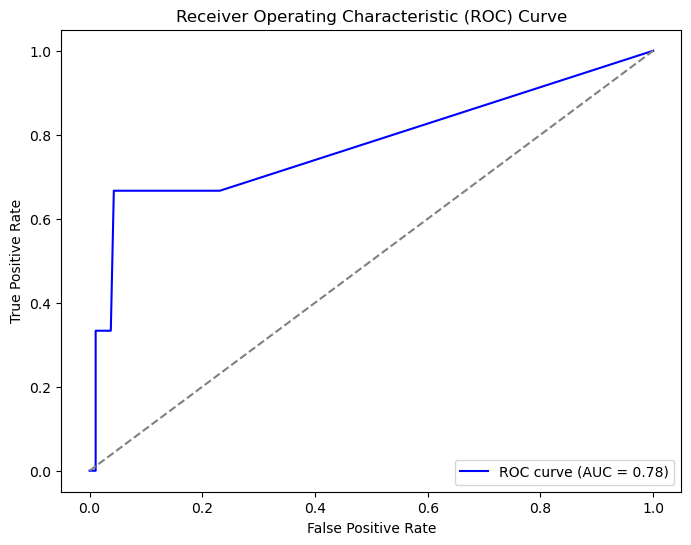

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
y_prob = model.predict_proba(lapData_test)[:, 1]  # Get probabilities for class 1

# Calculate ROC AUC
roc_auc = roc_auc_score(target_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(target_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [118]:
test= pd.DataFrame([9.0,8.0,2.0,9.0,44.0,0.0,14.0,24.0]).T
model.predict(test).value

NameError: name 'model' is not defined

In [312]:
pd.concat([pd.Series(lapData.columns),pd.Series(importances)], axis=1).sort_values(by=1, ascending=False)

,0,1
1,Position,0.269690
3,TyreLife,0.186185
4,TrackTemp,0.164510
7,RemainingLaps,0.149522
0,LapNumber,0.127028
6,RoundNumber,0.052019
2,Compound,0.044907
5,Rainfall,0.006138


# Agent builing time

## Set up

# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [ ]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class RaceState(TypedDict):
    """State representing the human startegies's pit stop conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The number of the race
    race_number: int

    # Weather data
    # [trackTemp, rainfall]
    weather: list[str]

    # The current race information
    # [tyre_life, compound, lap_remaining, position, stint,track_temp, weather]
    lap: list[str]

    # Flag indicating that the race is over.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
STRATEGYASSISTAN_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a Formula 1 strategy assistan, an interactive system that helps with pit atop decisions."
    "A human startegist will give you the necesary lap and weather information throughot a race and "
    "you have to tell them if they should pit the car for new tyres this lap or not. Besides this "
    "you may provaide confidence percentages in your decission and short reasoning of your decission "
    "but nothing else. In the beggining you will be given the round number of the race which you will "
    "have to store. You will also get the weather state at the beggining of the race which you'll "
    "have to structure and store untill you get an update. Than the human strategist will give you "
    "information about a single lap at a time which you'll have to structure and give to the classifier "
    "model. From the model you will get the decision (either to pit or to stay out) which you will "
    "communicate back to the human strategist."
    "/n/n"
    "You add the weather infromation with add_weather, and retrive it with get_weather (this is only for "
    "yourself, not the user)."
    "To store the race round number use store_race, adn to retrive it use get_race."
    "To get the decision to pit or not to pit used pit_check."
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",

    
    # "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    # "available products you have and you will answer any questions about menu items (and only about "
    # "menu items - no off-topic discussion, but you can chat about the products and their history). "
    # "The customer will place an order for 1 or more items from the menu, which you will structure "
    # "and send to the ordering system after confirming the order with the human. "
    # "\n\n"
    # "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    # "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    # "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    # "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    # "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    # "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    # "You only have the modifiers listed on the menu. "
    # "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    # "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    # "say goodbye!"
    # "\n\n"
    # "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    # "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Hey, I am your Strategy Assistent! What race can I help you with today?"

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
from langchain_core.messages.ai import AIMessage
from typing import Literal
from langchain_core.tools import tool


# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [ ]:
@tool
def update_weather(track_temp: int, rainfall: bool) -> str:
    """Update the weather information

    Returns:
        Weather updated message
    """
    
@tool
def get_weather() -> [str]:
    """Returns the latest weather data information"""


@tool
def store_race(race_number: int) -> str:
    """Stors the race round number
    
    Returns:
        Confirmation message 
    """

@tool
def get_race() -> int:
    """Returns the race round number"""

@tool
def pit_check(lap_number: float, position: float, tyre_life: float, compound: float, reamining_laps: float) -> int:
    """Feeds lap,wather and race information to the classifier
    
    
    Returns:
        The result from the classifier
    """

@tool
def tyre_compounds() -> str:
    """Tyre compound type integer quivalence dictionary"""

    
    return """
    HARD: 0.0,
    MEDIUM: 2.0,
    SOFT: 3.0,
    INTERMEDIATE: 1.0,
    WET: 4.0
    """


In [ ]:
# version before adding more features


def race_node(state: RaceState) -> RaceState:
    
    tool_msg = state.get("messages", [])[-1]
    weather = state.get("weather", [])
    race_number = state.get("race_number", [])
    lap = state.get("lap", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "update_weather":

            if weather == []:
                weather.append(f'{tool_call["args"]["track_temp"]}, {tool_call["args"]["rainfall"]}')
                response = "\n".join(weather)
            else:
                weather == []
                weather.append(f'{tool_call["args"]["track_temp"]}, {tool_call["args"]["rainfall"]}')
                response = "\n".join(weather)
            
        elif tool_call["name"] == "get_weather":

            response = "\n".join(weather) if weather else "No weather data"
            
        elif tool_call["name"] == "store_race":

            race_number.append(f'{tool_call["args"]["race_number"]}')
            response = '\n'.join(race_number[-1])
            
        elif tool_call["name"] =="get_race":

            response = "\n".join(race_number[-1]) if race_number else "No race data"
        
        elif tool_call["name"] == "pit_check":
                #'LapNumber', 'Position', 'Compound', 'TyreLife', 'TrackStatus',
                # 'TrackTemp', 'Rainfall', 'DeltaTime', 'GapAhead', 'PosToLose',
                # 'TotalLaps', 'RemainingLaps'

# calculate and store remaining lap
            
        # compound need to be encoded. encodding dictionarry needs to me added
            # compound = tyre_compounds[tool_call["args"]["compound"]]
            lap.append({tool_call["args"]["lap_number"]})
            lap.append({tool_call["args"]["position"]})
            lap.append({tool_call["args"]["compound"]})
            lap.append({tool_call["args"]["tyre_life"]})
            lap.append({weather[0]})
            lap.append({race_number[-1]})
            lap.append({tool_call["args"]["reamining_laps"]})

            # model_prediction = model.predict(lap)
            
            # response = "\n".join(model_prediction,f'{lap}')
            response ="\n".join(f'{lap}')
            
        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "weather": weather, "race_number": race_number, "lap": lap, "finished": order_placed}


def human_node(state: RaceState) -> RaceState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}
    

def maybe_exit_human_node(state: RaceState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


def chatbot_with_tools(state: RaceState) -> RaceState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"race_info": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([STRATEGYASSISTAN_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


def maybe_route_to_tools(state: RaceState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "racing"

    else:
        return "human"


# Start building a new graph.
graph_builder = StateGraph(RaceState)

# Race-tools will be handled by the race node.
race_tools = [update_weather, get_weather, store_race, get_race, pit_check]

tool_node = ToolNode([tyre_compounds, status])

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(race_tools)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("racing", race_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)


# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge('racing', "chatbot")
graph_builder.add_edge("tools", "chatbot")

chat_with_human_graph = graph_builder.compile()



In [ ]:
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [ ]:
from pprint import pprint

config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []}, config)
